In [1]:
import librosa
import librosa.display

import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
from numpy import *
from numpy import linalg as la

import pandas as pd

from sklearn.datasets import load_iris
from sklearn.mixture import GaussianMixture

from scipy.stats import norm

import seaborn as sns

# Evaluate using iris_data set

## load iris_data set

In [2]:
iris=load_iris()
features = iris.data
feature_names = iris.feature_names
target = iris.target
target_names = iris.target_names
data=features

pd.DataFrame(features, columns=feature_names)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


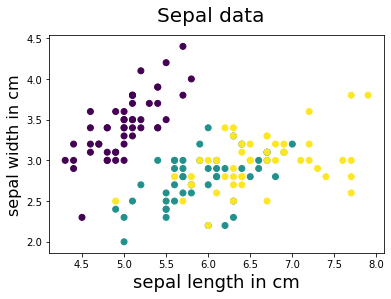

In [3]:
fig = plt.figure()

# set title and labels
fig.suptitle('Sepal data', fontsize=20)
plt.xlabel('sepal length in cm', fontsize=18)
plt.ylabel('sepal width in cm', fontsize=16)

# plot all samples
plt.scatter(features[:, 0], features[:, 1], c=target)
plt.show()

## Implemented EM algorithm

In [4]:
class_set = ['setosa','versicolor','virginica']
avg_set = []

# save sample data as matrix
X = empty((0))

# save number of cols and rows
sample_count = 0
feature_count = 0

# parameters of GMM
k = len(class_set)
init_cov = []
init_mu = []
init_phi = []

# output result
result = pd.DataFrame(columns=['sepal length', 'sepal width', 'petal length', 'petal width','class', 'Prob'])
centroids = []

In [5]:
# load data as numpy array
def load_data(data_set):
    X = mat(data_set.T[:].T)
    sample_count, feature_count = shape(X)
    avg_set = [average(col) for col in data_set.T[:]]

    return X, sample_count, feature_count, avg_set

# init parameters
def init_par(k, X, init_phi, init_mu, init_cov, feature_count):
    # init phi distribution
    for i in range(k):
        init_phi.append(1 / k)

    # randomly select k sample as initial mu of k class
    init_mu = [X[i, :] for i in random.randint(0,150,size=k)]

    # init identity matrix as initial covariance matrix
    init_cov = [mat(np.identity(feature_count)) for _ in range(k)]
    
    return init_phi, init_mu, init_cov

In [6]:
X, sample_count, feature_count, avg_set = load_data(features)
init_phi, init_mu, init_cov = init_par(k, X, init_phi, init_mu, init_cov, feature_count)

In [7]:
print(init_phi, len(init_phi))
print(init_mu, len(init_mu))
print(init_cov, len(init_cov))

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333] 3
[matrix([[6.9, 3.2, 5.7, 2.3]]), matrix([[5.7, 2.6, 3.5, 1. ]]), matrix([[5.4, 3.4, 1.7, 0.2]])] 3
[matrix([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]), matrix([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]), matrix([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])] 3


In [8]:
# calculate multivariate Normal distribution probabilities of each sample(gamma)
def G_prob(x, mu, cov):
    n = len(x[0])
    e_power = float(-0.5 * (x - mu) * (cov.I) * ((x - mu).T))
    Deno = power(2 * pi, n / 2) * power(linalg.det(cov), 0.5)
    gamma = power(e, e_power) / Deno
    return gamma

# implement EM Algorithm
def EM(X, init_phi, init_cov, init_mu, k, sample_count, feature_count):

    # init parameters
    phi = init_phi
    cov = init_cov
    mu = init_mu

    # init probabilities set
    gamma = mat(zeros((sample_count, k)))

    # Start Iteration
    dif = 1
    threshold = 1e-3
    while dif > threshold:
        mu_pre = [item for item in mu]
        # step E
        for j in range(sample_count):
            px = 0
            for i in range(k):
                gamma[j, i] = phi[i] * G_prob(X[j, :], mu[i], cov[i])
                px += gamma[j, i]
            for i in range(k):
                gamma[j, i] /= px
        sum_gamma = sum(gamma, axis=0)

        # step M
        for i in range(k):
            mu[i] = mat(zeros((1, feature_count)))
            cov[i] = mat(zeros((feature_count, feature_count)))
            for j in range(sample_count):
                mu[i] += gamma[j, i] * X[j, :]
            mu[i] /= sum_gamma[0, i]
            for j in range(sample_count):
                cov[i] += gamma[j, i] * (X[j, :] - mu[i]).T * (X[j, :] - mu[i])
            cov[i] /= sum_gamma[0, i]
            phi[i] = sum_gamma[0, i] / sample_count

        # check whether mu are convergence
        dif = 0
        for i in range(k):
            distance = (mu[i]-mu_pre[i])*(mu[i]-mu_pre[i]).T
            dif += distance[0,0]
    return gamma

# cluster samples to k groups
def cluster(X, init_phi, init_cov, init_mu, k, sample_count, feature_count, result, centroids):
    # init centroids set for different classes
    gamma = EM(X, init_phi, init_cov, init_mu, k, sample_count, feature_count)
    classification = mat(zeros((sample_count, 2)))


    for i in range(sample_count):
        # Align to groups (return the index of biggest probability, and such prob)
        classification[i, :] = argmax(gamma[i, :]), amax(gamma[i, :])
        temp = [item for item in squeeze(np.asarray(X[i, :]))] + [argmax(gamma[i, :]), amax(gamma[i, :])]
        result.loc[i] = temp

        # update centroids
    for j in range(k):
        pointsInCluster = X[nonzero(classification[:, 0].A == j)[0]]
        centroids.append(mean(pointsInCluster, axis=0))

    # set 'class' column data type to int
    result['class'] = pd.to_numeric(result['class'], downcast='signed', errors='coerce')
    
    return result, centroids

In [9]:
result, centroids = cluster(X, init_phi, init_cov, init_mu, k, sample_count, feature_count, result, centroids)

In [10]:
print(result)

     sepal length  sepal width  petal length  petal width  class      Prob
0             5.1          3.5           1.4          0.2      2  1.000000
1             4.9          3.0           1.4          0.2      2  1.000000
2             4.7          3.2           1.3          0.2      2  1.000000
3             4.6          3.1           1.5          0.2      2  1.000000
4             5.0          3.6           1.4          0.2      2  1.000000
..            ...          ...           ...          ...    ...       ...
145           6.7          3.0           5.2          2.3      0  1.000000
146           6.3          2.5           5.0          1.9      0  0.999496
147           6.5          3.0           5.2          2.0      0  0.997426
148           6.2          3.4           5.4          2.3      0  0.999992
149           5.9          3.0           5.1          1.8      0  0.894120

[150 rows x 6 columns]


In [11]:
print(result['class'].values.tolist())
print('-----')
print(target)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
-----
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [12]:
# Label replacement
predicted_label = result['class'].values.tolist().copy()
# Calculate accuracy
print(sum(predicted_label == target) / len(predicted_label))

0.32


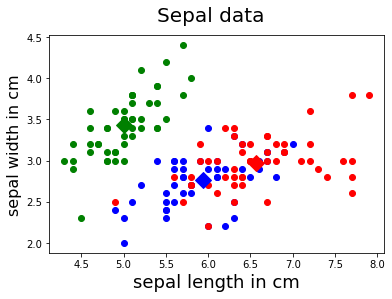

In [13]:
# set dot type and color
mark_sample = ['ro', 'bo', 'go', 'ok']
mark_centroids = ['Dr', 'Db', 'Dg', 'Dk']
if k > len(mark_sample):
    print("k is too large")

fig = plt.figure()
# plot all samples
for i in range(sample_count):
    markIndex = result['class'].iloc[i]
    plt.plot(result['sepal length'].iloc[i], result['sepal width'].iloc[i], mark_sample[markIndex])

# plot centroids
for i in range(k):
    plt.plot(centroids[i][0, 0], centroids[i][0, 1], mark_centroids[i], markersize=12)

# set title and labels
fig.suptitle('Sepal data', fontsize=20)
plt.xlabel('sepal length in cm', fontsize=18)
plt.ylabel('sepal width in cm', fontsize=16)

plt.show()

## Existing function

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.20)


In [15]:
n_classes = len(np.unique(y_train))
print(n_classes)

3


In [16]:
classifiers = dict((covar_type, GaussianMixture(n_components=n_classes,
                    covariance_type=covar_type, max_iter=1000, tol=0.0001))
                   for covar_type in ['spherical', 'diag', 'tied', 'full'])

n_classifiers = len(classifiers)

In [17]:
for index, (name, classifier) in enumerate(classifiers.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    classifier.means_ = np.array([X_train[y_train == i].mean(axis=0)
                                  for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    classifier.fit(X_train)
    Y_predict = classifier.predict(np.array(X_test))
    
    print(classifier)
    print(Y_predict, y_test)
    # Calculate accuracy
    print(sum(y_test == Y_predict) / len(y_test))

GaussianMixture(covariance_type='spherical', max_iter=1000, n_components=3,
                tol=0.0001)
[1 1 2 2 0 0 1 0 2 1 0 1 0 2 1 1 1 0 0 0 0 2 2 1 0 0 2 1 0 0] [0 0 2 2 1 1 0 1 2 0 1 0 1 2 0 0 0 2 1 1 2 2 2 0 1 2 2 0 1 1]
0.23333333333333334
GaussianMixture(covariance_type='diag', max_iter=1000, n_components=3,
                tol=0.0001)
[1 1 0 2 0 0 1 0 2 1 0 1 0 2 1 1 1 0 0 0 0 2 2 1 0 0 2 1 0 0] [0 0 2 2 1 1 0 1 2 0 1 0 1 2 0 0 0 2 1 1 2 2 2 0 1 2 2 0 1 1]
0.2
GaussianMixture(covariance_type='tied', max_iter=1000, n_components=3,
                tol=0.0001)
[0 0 1 2 1 1 0 1 2 0 1 0 1 2 0 0 0 2 1 1 2 2 2 0 1 1 2 0 1 1] [0 0 2 2 1 1 0 1 2 0 1 0 1 2 0 0 0 2 1 1 2 2 2 0 1 2 2 0 1 1]
0.9333333333333333
GaussianMixture(max_iter=1000, n_components=3, tol=0.0001)
[1 1 2 2 0 0 1 0 2 1 2 1 0 2 1 1 1 2 0 0 2 2 2 1 0 2 2 1 0 0] [0 0 2 2 1 1 0 1 2 0 1 0 1 2 0 0 0 2 1 1 2 2 2 0 1 2 2 0 1 1]
0.3333333333333333


In [18]:
#df = pd.DataFrame(features, columns=feature_names)
#df['label'] = target
#
## 種類 (ラベル) によって、サンプル数を変えます
#d1 = df[df['label'] == 0].sample(50)  # setosa
#d2 = df[df['label'] == 1].sample(50)  # versicolor
#d3 = df[df['label'] == 2].sample(50)  # virginica
#
## 萼片長のデータのみを使う
#X = pd.concat([d1['sepal length (cm)'], d2['sepal length (cm)'], d3['sepal length (cm)']])
#Y = pd.concat([d1['label'], d2['label'], d3['label']])
#
## ヒストグラム
#plt.hist([X[Y==0], X[Y==1], X[Y==2]], bins=np.arange(X.min(), X.max(), 0.2), stacked=True, label=iris.target_names)
#plt.legend()
#plt.plot()

X = features
Y = target

In [19]:
# training GaussianMixture
gmm = GaussianMixture(
    n_components=3,
    covariance_type='spherical',
    max_iter=1000,
    tol=0.0001
).fit(
    #np.array(X).reshape(-1, 1)  # 次元数2を入力とするため変形
    np.array(X)
)

# weights
print(gmm.weights_)

# Mean parameters
print(gmm.means_)

# Covariance parameters
print(gmm.covariances_)

[0.41424139 0.33333333 0.25242528]
[[5.90559615 2.74897543 4.40306782 1.43281519]
 [5.006      3.428      1.462      0.246     ]
 [6.84687497 3.07388893 5.73133465 2.07507737]]
[0.16336052 0.075756   0.16276365]


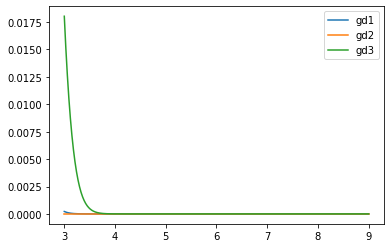

In [20]:
x = np.linspace(3, 9, 600)

gd1 = norm.pdf(x, gmm.means_[0, -1], np.sqrt(gmm.covariances_[0]))
gd2 = norm.pdf(x, gmm.means_[1, -1], np.sqrt(gmm.covariances_[1]))
gd3 = norm.pdf(x, gmm.means_[2, -1], np.sqrt(gmm.covariances_[2]))
    
plt.plot(x, gmm.weights_[0] * gd1, label='gd1')
plt.plot(x, gmm.weights_[1] * gd2, label='gd2')
plt.plot(x, gmm.weights_[2] * gd3, label='gd3')
plt.legend()
plt.show()

In [21]:
# Distribution prediction
#Y_predict = gmm.predict(np.array(X).reshape(-1, 1))
Y_predict = gmm.predict(np.array(X))
print(Y_predict, len(Y_predict))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0] 150


In [22]:
# Calculate accuracy
print(sum(Y == Y_predict) / len(Y))

0.24


In [23]:
# Label replacement
Y_new = Y.copy()
for i in range(len(Y_new)):
    if Y_new[i] == 0:
        Y_new[i] = 1
    elif Y_new[i] == 1:
        Y_new[i] = 0
    elif Y_new[i] == 2:
        Y_new[i] = 2

# Calculate accuracy
print(sum(Y_new == Y_predict) / len(Y_new))

0.8933333333333333


# Evaluate using the vowel mfcc

In [8]:
filepath = '/opt/share/takkan/samples/aiueo_trimmed.wav'
n_mfcc = 20
sr = 16000
signal, _ = librosa.load(filepath, sr=sr)
mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)

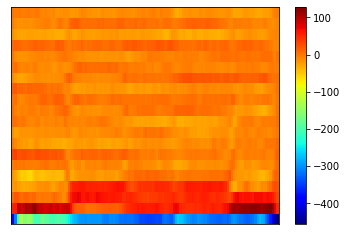

In [9]:
fig = plt.figure()
librosa.display.specshow(mfcc, cmap='jet')
plt.colorbar()
plt.show()

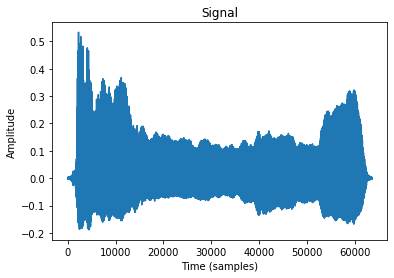

In [10]:
fig = plt.figure()
plt.plot(signal)
plt.title('Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
fig.show()

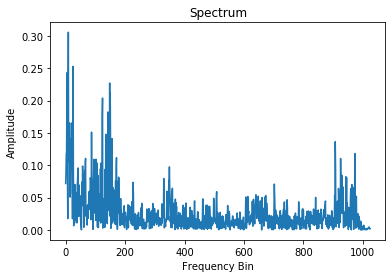

In [11]:
n_fft = 2048
signal_ft = np.abs(librosa.stft(signal[:n_fft], hop_length = n_fft+1))

fig = plt.figure()
plt.plot(signal_ft)
plt.title('Spectrum')
plt.xlabel('Frequency Bin')
plt.ylabel('Amplitude')
fig.show()